# Knife or Not Model:

# Training an Image Classifier

I have a dataset of images gathered from Google Images in my [prior notebook](https://github.com/buttchurch/knife-or-not/blob/master/create-dataset.ipynb), so now I can get to training a model. I'm following in Crocodile Dundee's cliched footsteps and recognizing whether or not a given image is a knife (or not).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *

from fastai.transforms import *
from fastai.models import *
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

# First look at images

After the necessary imports, I'll explore the dataset a little. I'm just getting a sense of what the data is, what kind of data augmentation I can do and make sure everything is looking good.

In [3]:
#set a working PATH
PATH = 'knife-or-not-data/'
sz = 224

In [4]:
os.listdir(PATH)

['valid', 'models', 'train', 'tmp']

In [5]:
os.listdir(f'{PATH}valid')

['knife', 'not_knife']

In [6]:
#first 5 knife pictures in valid folder
files = os.listdir(f'{PATH}valid/knife')[:5]
files

['tur_folding_knives.jpg',
 'eickhorn-km5000-half-serrated-8251382.jpg',
 'steigerwalt-ken-custom-di-hunting-knife.jpg',
 'evercut-furtif-chefs-knife-from-france-900x675.jpg',
 'yunaknives_com_1_homeimg1_r2_1548.jpg']

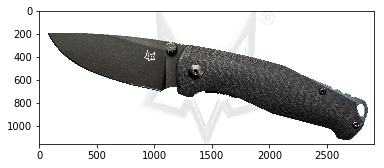

In [7]:
img = plt.imread(f'{PATH}valid/knife/{files[0]}')
plt.imshow(img)

Yep, that's definitely a knife.

In [26]:
#size of image: 3d array (the third dimension is for RGB)
img.shape

(1154, 2911, 3)

# First Model

I'll start with a simple, quick model as a starting point– this is where the fast.ai library comes in.

In [27]:
arch= resnet34
data = ImageClassifierData.from_paths(PATH, tfms = tfms_from_model(arch,sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(.01, 2)

  2%|▏         | 2/91 [00:04<03:41,  2.48s/it]

OSError: Error handling image at: knife-or-not-data/train/knife/?media_id=10156200219179304.jpg

Whoops! Error. Looks like I have some corrupted images in the dataset. I guess that's no surprise since this dataset came from Google Images. Using the error traceback, this block below can find the corrupt files/remove them.

In [33]:
directories = ['train/knife', 'train/not_knife', 'valid/knife', 'valid/not_knife']
corrupted = []
for directory in directories:
    for filename in os.listdir(f'{PATH}{directory}'):
        try:
            cv2.imread(f'{PATH}{directory}/{filename}').astype(np.float32)/255
        except:
            corrupted.append(directory + '/' + filename)

In [34]:
corrupted[:5]

['train/knife/?media_id=10156200219179304.jpg',
 'train/knife/?media_id=285698251613608.jpg',
 'train/knife/?media_id=1889976407735698.jpg',
 'train/knife/.DS_Store',
 'train/knife/?media_id=1762063614087630.jpg']

In [35]:
for file in corrupted:
    os.remove(f'{PATH}{file}')

Ok, corruptions cleansed. Let's try our initial model again.

In [8]:
arch= resnet34
data = ImageClassifierData.from_paths(PATH, tfms = tfms_from_model(arch,sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(.01, 2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.162507   0.090702   0.964236  
    1      0.129287   0.080952   0.969144                  



[array([0.08095]), 0.9691444600280504]

It works! And in literally a few seconds, I have almost **97% accuracy**.


# Analysing results

Before I improve the model any further, a bit of probing to see what the model got correct/incorrect and how I can improve it.

In [9]:
#these are the validation labels
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [10]:
#We see that 0 is 'knife' and 1 is 'not_knife'
data.classes

['knife', 'not_knife']

In [11]:
log_preds = learn.predict()
log_preds.shape

(1426, 2)

In [12]:
#predictions come out in log scale
log_preds[:10]

array([[-0.00898, -4.71704],
       [-0.00549, -5.20702],
       [-0.0029 , -5.84514],
       [-0.00042, -7.77589],
       [-0.00079, -7.14675],
       [-0.00066, -7.33116],
       [-0.00116, -6.75582],
       [-0.00303, -5.79994],
       [-0.00079, -7.14066],
       [-0.00011, -9.12462]], dtype=float32)

In [13]:
preds = np.argmax(log_preds, axis=1) #log_preds to 0 or 1 prediction
probs = np.exp(log_preds[:,1])

In [14]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs= [load_img_id(data.val_ds, x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct):
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

### Most correct predictions

Most correct knives


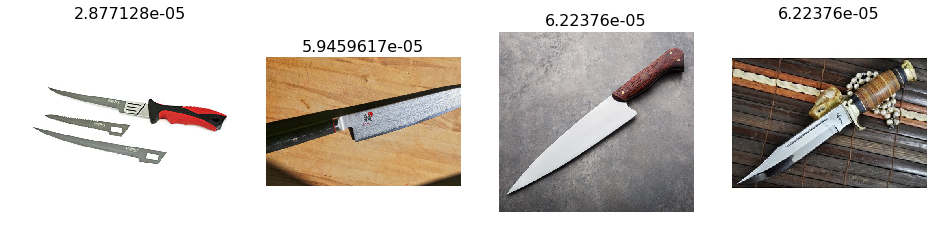

In [21]:
plot_val_with_title(most_by_correct(0, True), "Most correct knives")

Yeah, those knives are very knife-y. I wasn't sure that Image Classification would work well with negative categories (that is, *not* something), but it seems to do just fine even though the data is (by definition) all over the place.

Most correct not-knives


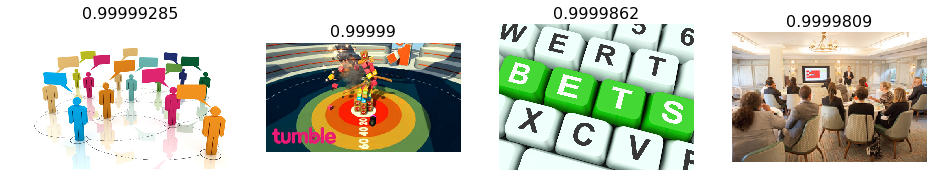

In [22]:
plot_val_with_title(most_by_correct(1,True), "Most correct not-knives")

### Least correct predictions

Most incorrect knives


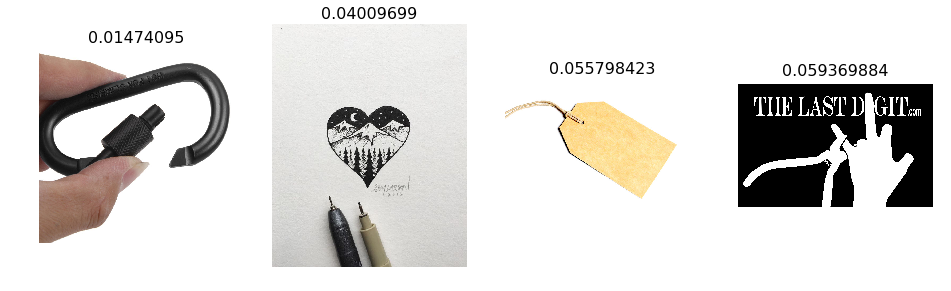

In [23]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect knives")

I've only trained the model very briefly, but can see that things with hard edges have a chance at fooling the model.

Most incorrect not-knives


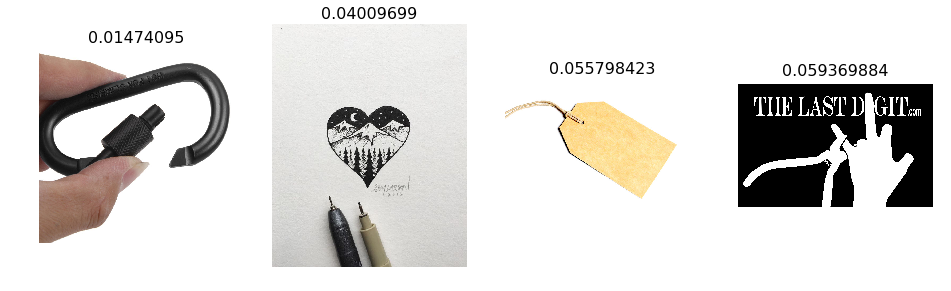

In [24]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect not-knives")

Most uncertain predictions


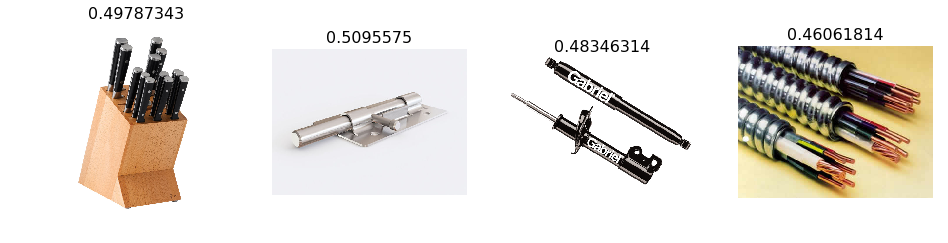

In [25]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

Interesting to see what images the model can't really decide on.

# Further Training

### Data Augmentation

When you're working with images, one of the best ways to improve your model is to use your current data to easily generate new, slightly different images to *augment* the training set. For example, rotating an image by 5 or 10 degrees, zooming in or cropping slightly. This not only gives the model more data to train with (always good), but helps make sure the model is learning to recognize knives in *general*, rather than simply the exact knives that we are showing it.

In [32]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers = 1)
    x, _ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

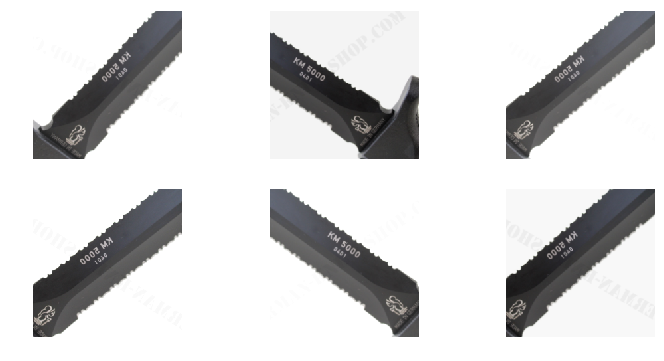

In [33]:
ims = np.stack([get_augs() for i in range(6)])

plots(ims, rows=2)

See how one image is now multiplied into many images? We'll create a new data object that includes these augmentations for each image.

In [57]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [58]:
learn.fit(1e-2, 4)

epoch      trn_loss   val_loss   accuracy                  
    0      0.170318   0.085529   0.969144  
    1      0.125517   0.073847   0.972651                  
    2      0.113372   0.082547   0.97195                   
    3      0.106291   0.068605   0.97195                   


[array([0.06861]), 0.9719495091164095]

In [59]:
learn.precompute= False

In [60]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      0.113488   0.068721   0.974053  
    1      0.109169   0.071096   0.973352                  
    2      0.103265   0.06382    0.975456                   


[array([0.06382]), 0.9754558204768583]

This whole time, I've only been training the last layer of my deep learning model. The earlier layers were set with "transfer learning". But now that I have a pretty good final layer going, I can **unfreeze** the earlier layers, allowing them to mold to this particular classification problem.

In [61]:
learn.unfreeze()

In [62]:
lr=np.array([1e-4,1e-3,1e-2])

In [63]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.126954   0.081875   0.970547  
    1      0.105351   0.064107   0.975456                  
    2      0.086589   0.062163   0.97756                    
    3      0.087246   0.057175   0.981066                   
    4      0.067972   0.053643   0.982468                   
    5      0.053627   0.053272   0.981066                   
    6      0.047974   0.052318   0.980365                   


[array([0.05232]), 0.9803646563814866]

See how the training loss has now become lower than my validation loss? I've trained this particular model as far as I can go and I'm starting to overfit.

In [64]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)

In [65]:
accuracy_np(probs, y)

0.9831697054698457

In the end, my model got to 98.3% accuracy! What does that mean exactly?

# Analysing results

### Confusion matrix

In [66]:
preds = np.argmax(probs, axis = 1)
probs = probs[:,1]

[[863  13]
 [ 11 539]]


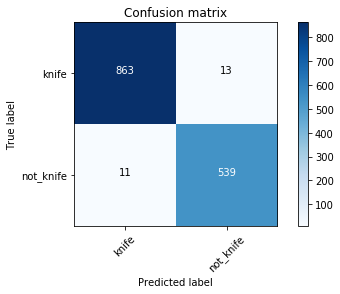

In [67]:
from sklearn.metrics import confusion_matrix
cm= confusion_matrix(y, preds)

plot_confusion_matrix(cm, data.classes)

So for knives, the model called 863 right and missed 13 of them. Likewise for not-knives, it got 539 correct but missed on 11.

### Look at pictures again

Most incorrect knives


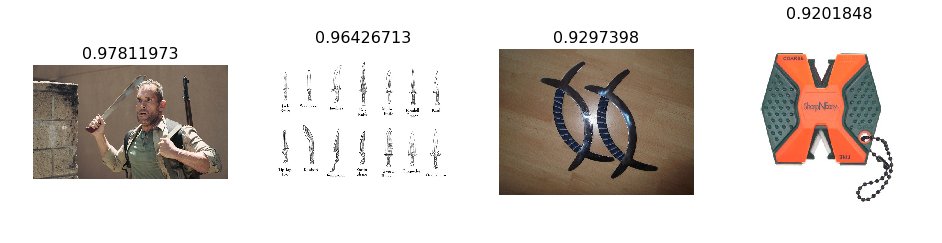

In [68]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect knives")

To a certain extent, the model is just running up against the weirdness of Google Image searches.

Most incorrect not-knives


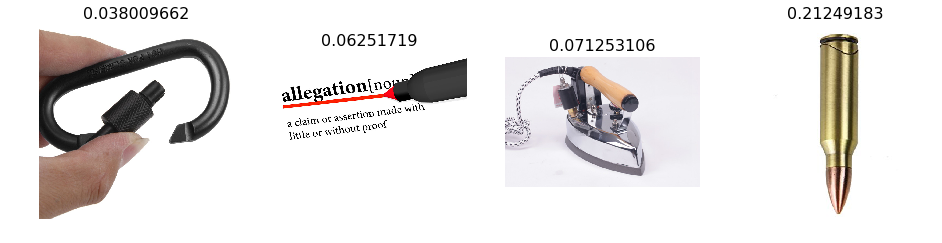

In [69]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect not-knives")

# Conclusion

That's it for modeling! In the prior notebook I created the dataset from scratch, here I have used it to train a model to 98% accuracy.

I'm excited to move on to other problems (Natural Language Processing, in particular), but at some point a fun third phase of this project could be putting this model to use in an end-product. For example, embedding this model into a Django site that anyone can use to test their own knives.

### What I learned

This was my first deep learning project, and so much learning had to happen to make even this silly little notebook possible. I've been neck deep in [fast.ai](http://www.fast.ai/)'s deep learning courses for almost half a year, and taking Python courses at the same time to try to get a little bit of coding proficiency, since that is really how all this stuff is done. If you can't code, you can't do anything with deep learning. 

One concrete thing I learned was using Jupyter's error traceback to filter out corrupted files in a dataset. That's a nifty trick.